In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False


Download example weather data

In [4]:
csv_path = "C:\\Users\\svea\\DataMining\\feinstaubprojekt-polen\\data\\pollution\\2022_16_101.csv"


Change Intervall size to hours

In [10]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")

df


,date,value
0,2022-01-01 00:00:00,5.37569
1,2022-01-01 01:00:00,24.96140
2,2022-01-01 02:00:00,4.70004
3,2022-01-01 03:00:00,5.75185
4,2022-01-01 04:00:00,9.26986
...,...,...
8697,2022-12-31 19:00:00,7.60558
8698,2022-12-31 20:00:00,6.24509
8699,2022-12-31 21:00:00,4.26575
8700,2022-12-31 22:00:00,3.63241


Inspect data

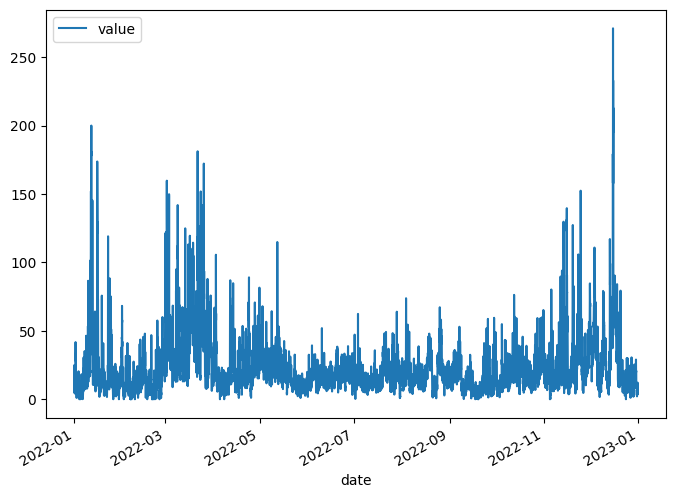

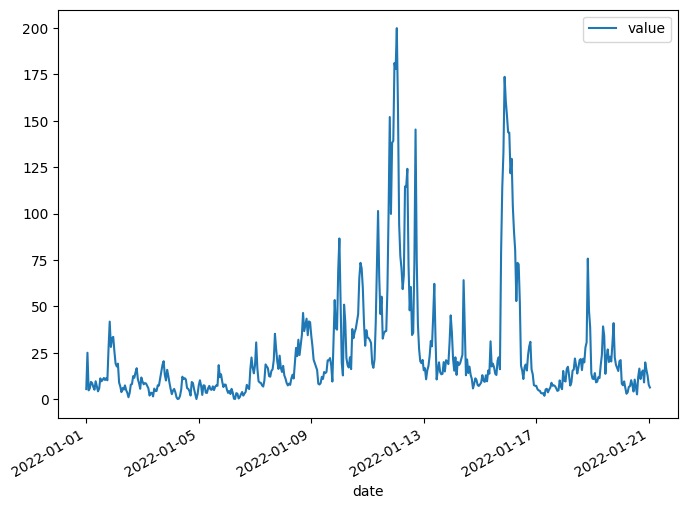

In [11]:
plot_cols = ["value"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


Statistic of data

In [12]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
value,8702.0,22.770377,20.418823,0.0,10.6628,17.29435,27.40905,271.011


clean up

Feature Engineering
- convert wind to vector

- time format in seconds
- to use in model seconds not absolute but create a periodicity (daily, yearly)

In [13]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))


Text(0.5, 1.0, 'Time of day signal')

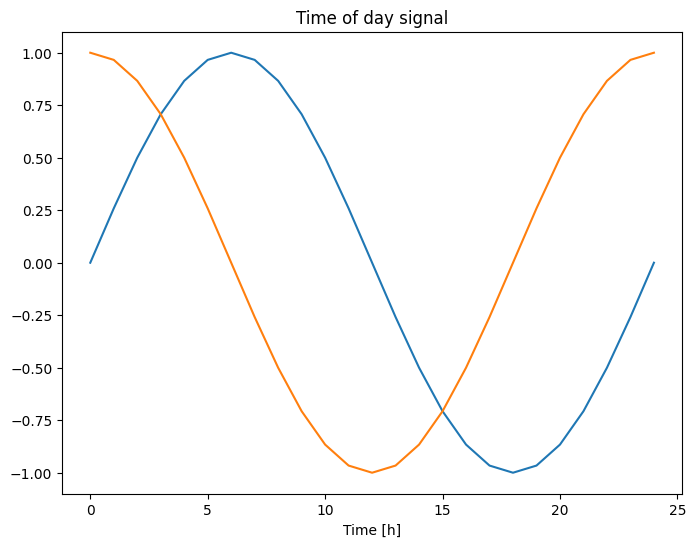

In [14]:
plt.plot(np.array(df["Day sin"])[:25])
plt.plot(np.array(df["Day cos"])[:25])
plt.xlabel("Time [h]")
plt.title("Time of day signal")


Split data into train, validation and test

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]


Normalization of data

In [109]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std


In [ ]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)


Data windowing

In [16]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["value"])
w1


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['value']

In [19]:
w2 = WindowGenerator(input_width=336, label_width=1, shift=336, label_columns=["value"])
w2


Total window size: 672
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [20]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window


In [116]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")


KeyError: 'T (degC)'

Database erstellen

Multi-step model

ValueError: x and y must have same first dimension, but have shapes (24,) and (6,)

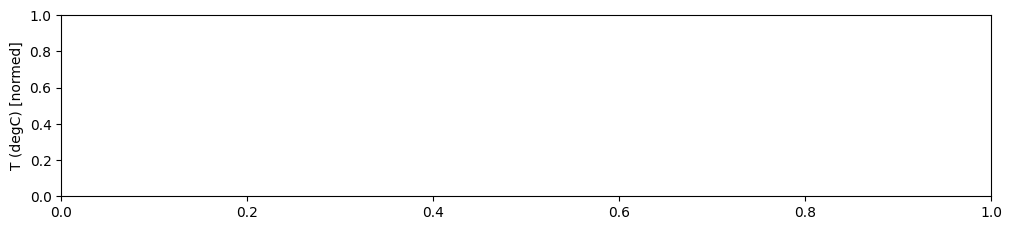

In [ ]:
## 24 Stunden Vorhersage mit 24 Stunden Historie
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
multi_window.example = example_inputs, example_labels
multi_window.plot()
multi_window
